In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/CS6220'
%cd $path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CS6220


In [4]:
import json
import pandas as pd
import os
import networkx as nx
import numpy as np
import subprocess
from collections import defaultdict
from collections import Counter
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import time

# Hyperparameters
# Hyperparameters
alpha1 = 0
alpha2 = 1
beta1 = 1
beta2 = 2
gamma1 = 0
gamma2 = 2
gamma3 = 1

max_epochs = 1000
k = 3

t1 = time.time()

# Files
ori_data = f'dataset/processed_80_20_all.csv'
# toy_data = f'dataset/toy_{k}-core_80_20_all.csv'
ori_label_data = f'dataset/user_label_all.csv'
# toy_label_data = f'dataset/toy_label_all.csv'

benign = []
fraudulent = []
total_users = 0

with open(ori_label_data, 'r') as f:
    f.readline()
    for l in f:
        total_users += 1
        s = l.rstrip('\n').split(',')
        if s[2] == 'Benign':
            benign.append(s[0])
        else:
            fraudulent.append(s[0])
print(total_users)

# Convert to networkx
df = pd.read_csv(ori_data)
df['reviewerID'] = 'u' + df['reviewerID'].astype(str)
df['asin'] = 'p' + df['asin'].astype(str)
X = df[['reviewerID', 'asin', 'rating']]
print(X)
G = nx.from_pandas_edgelist(X, source = 'reviewerID', target = 'asin', edge_attr=True, create_using=nx.DiGraph())

nodes = G.nodes()
edges = G.edges(data=True)
print(f"Amazon Network has {len(nodes)} nodes and {len(edges)} edges")

19677
             reviewerID         asin  rating
0        uAMFYF3C08JMWD  p0071760520     0.5
1       uA2B8GXSCB1R05T  p0061230936     0.0
2       uA1MC81HLJ6Z9ZQ  p0060935766    -0.5
3        uAHUT55E980RDR  p0123855489     1.0
4       uA1CNXVJ4KWIOTY  p0140231617     1.0
...                 ...          ...     ...
141813  uA1BTKAEXPIBKYZ  p0060001534     1.0
141814  uA2Z99IBH9BI4XJ  p0060925760     1.0
141815  uA1VX6VPXNQTNUP  p0061170917     0.5
141816  uA359D655P5XEU4  p0061233781     0.5
141817   uAN0N05A9LIJEQ  p0061351601     1.0

[141818 rows x 3 columns]
Amazon Network has 41931 nodes and 141818 edges


In [5]:
user_names = [node for node in nodes if node.startswith('u')]
product_names = [node for node in nodes if node.startswith('p')]
num_users = len(user_names)
num_products = len(product_names)
user_map = dict(zip(user_names, range(len(user_names))))
product_map = dict(zip(product_names, range(len(product_names))))

# Give initial values to each node, product and edge
for node in nodes:
      if node.startswith("u"):
          G.nodes[node]["fairness"] = 1
      else:
          G.nodes[node]["goodness"] = 1

for edge in edges:
    G[edge[0]][edge[1]]["fairness"] = 1

In [6]:
# Update product goodness scores
def Updating_goodness_of_product():
    print('Updating goodness of product')

    def calc_Gp(node):
        inedges = G.in_edges(node, data=True)

        ftotal = len(inedges)
        gtotal = np.sum([edge[2]["fairness"] * edge[2]["rating"]
                          for edge in inedges])

        if ftotal > 0.0:
            mean_rating_fairness = (
                gtotal + beta1*median_gvals) / (ftotal + beta1)
        else:
            mean_rating_fairness = 0.0

        mean_rating_fairness = np.clip(
            mean_rating_fairness, -1, 1)

        return mean_rating_fairness

    # goodness of the curretn products
    currentgvals = [G.nodes[node]["goodness"]
                    for node in nodes if 'p' == node[0]]
    # median
    median_gvals = np.median(currentgvals)

    dp = 0
    for node in nodes:
        if "p" not in node[0]:
            continue

        x = calc_Gp(node)
        dp += abs(G.nodes[node]["goodness"] - x)
        G.nodes[node]["goodness"] = x

    return dp

In [7]:
# Update rating fairness scores
def Updating_fairness_of_ratings():
    print("Updating fairness of ratings")

    def calc_FR(edge):
        user_fairness = G.nodes[edge[0]]["fairness"]  # F(u)

        rating_distance = 1 - \
            (abs(edge[2]["rating"] - G.nodes[edge[1]]["goodness"]) / 2.0)

        x = (gamma1 * user_fairness + gamma2 *
              rating_distance) / (gamma1 + gamma2)
        x = np.clip(x, 0, 1)
        return x

    dr = 0

    for edge in edges:
        x = calc_FR(edge)
        dr += abs(edge[2]["fairness"] - x)
        G.adj[edge[0]][edge[1]]["fairness"] = x
    return dr

In [8]:
# Update user fairness scores
def Updating_fairness_of_users():
    print('updating fairness of users')

    def calc_FU(node):
        outedges = G.out_edges(node, data=True)
        rating_fairness_sum = np.sum(
            [edge[2]["fairness"] for edge in outedges])

        x = (rating_fairness_sum + alpha1*median_fvals) / \
            (len(outedges) + alpha1)
        x = np.clip(x, 0, 1)
        return x

    currentfvals = [G.nodes[node]["fairness"]
                    for node in nodes if 'u' == node[0]]
    # Alternatively, we can use mean here, intead of median
    median_fvals = np.median(currentfvals)

    du = 0

    for node in nodes:
        if "u" not in node[0]:
            continue

        x = calc_FU(node)
        du += abs(G.nodes[node]["fairness"] - x)
        G.nodes[node]["fairness"] = x

    return du

In [9]:
# REV2 algorithm
# Iterate to update parameters
du = 0
dp = 0
dr = 0

for epoch in range(max_epochs):
    print('-----------------')
    print("Epoch number %d with du = %f, dp = %f, dr = %f, for (%d,%d,%d,%d,%d,%d,%d)" % (
        epoch, du, dp, dr, alpha1, alpha2, beta1, beta2, gamma1, gamma2, gamma3))
    if np.isnan(du) or np.isnan(dp) or np.isnan(dr):
        break

    dp = Updating_goodness_of_product()
    dr = Updating_fairness_of_ratings()
    du = Updating_fairness_of_users()

    if du < 0.01 and dp < 0.01 and dr < 0.01:
        break

-----------------
Epoch number 0 with du = 0.000000, dp = 0.000000, dr = 0.000000, for (0,1,1,2,0,2,1)
Updating goodness of product
Updating fairness of ratings
updating fairness of users
-----------------
Epoch number 1 with du = 4430.170421, dp = 6530.317052, dr = 23739.474869, for (0,1,1,2,0,2,1)
Updating goodness of product
Updating fairness of ratings
updating fairness of users
-----------------
Epoch number 2 with du = 477.105296, dp = 2097.748385, dr = 5218.531580, for (0,1,1,2,0,2,1)
Updating goodness of product
Updating fairness of ratings
updating fairness of users
-----------------
Epoch number 3 with du = 220.775450, dp = 1023.582849, dr = 2006.329324, for (0,1,1,2,0,2,1)
Updating goodness of product
Updating fairness of ratings
updating fairness of users
-----------------
Epoch number 4 with du = 91.897437, dp = 408.264059, dr = 754.410954, for (0,1,1,2,0,2,1)
Updating goodness of product
Updating fairness of ratings
updating fairness of users
-----------------
Epoch numbe

In [10]:
# Make a directory to save results
Path = './rev2_results/'
if not os.path.exists(Path):
    os.mkdir(Path)
os.listdir('./')

['2_2_TF-IDF_Embedding.ipynb',
 'Presentation07_S22.pdf',
 'README.md',
 '3_Proposed_Methods.ipynb',
 '2_1_Bert_Embedding.ipynb',
 'Report07_S22.pdf',
 'ratings_Musical_Instruments.csv',
 'reviews_Musical_Instruments_5.json.gz',
 'preprocessing.ipynb',
 'data',
 'reviews_Musical_Instruments.json.gz',
 'dataset',
 'rev2_results',
 'musical_reviews.pickle',
 'test.ipynb',
 'gnn_results_withID.csv',
 'gnn_results2_withID.csv',
 'preds_gt.csv',
 'merge_csv.ipynb',
 '1_Dataset_preprocessing.ipynb',
 'reviewer_preds_gt.csv',
 'metrics_results.csv',
 'kcore_5.json.gz',
 '4_Baseline.ipynb']

In [11]:
# Make tables to see the score of each user and product
currentfvals = []
for node in nodes:
  if "u" not in node[0]:
    continue
  currentfvals.append(G.nodes[node]["fairness"])
median_fvals = np.median(currentfvals)

user_fairness_df = pd.DataFrame([(x[0], x[1]['fairness']) for x in G.nodes(
                data=True) if x[0].startswith('u')], columns=['source', 'fairness'])
product_goodness_df = pd.DataFrame([(x[0], x[1]['goodness']) for x in G.nodes(data=True) if x[0].startswith('p')],
                    columns=['target', 'goodness'])
edge_fairness_df = nx.to_pandas_edgelist(G)
print(user_fairness_df)

                source  fairness
0       uAMFYF3C08JMWD  0.896907
1      uA2B8GXSCB1R05T  0.819887
2      uA1MC81HLJ6Z9ZQ  0.785119
3       uAHUT55E980RDR  0.830923
4      uA1CNXVJ4KWIOTY  0.846923
...                ...       ...
19672  uA2KDQAUG8VUVMM  0.403996
19673   uAFC57IM2AMDMX  0.523441
19674  uA3CJHEDIS4W775  0.756734
19675  uA1666TAW3ZF0NW  0.758715
19676   uAQBEP59USS7QR  0.893519

[19677 rows x 2 columns]


In [12]:
all_node_vals = []
fair_node_vals = []

for node in nodes:
    if "u" not in node[0]:
        continue
    f = G.nodes[node]["fairness"]
    all_node_vals.append(
        [node, (f - median_fvals) * np.log(G.out_degree(node) + 1), f, G.out_degree(node)])
    fair_node_vals.append(
        [node[1:], (f - median_fvals) * np.log(G.out_degree(node) + 1)])

all_node_vals_sorted = sorted(all_node_vals, key = lambda x: (float(x[1]), float(x[2]), -1 * float(x[3])), reverse=True)
fair_node_vals_sorted = sorted(fair_node_vals, key = lambda x: (float(x[1])), reverse=True)
print(all_node_vals_sorted[:100])

[['uAG35NEEFCMQVR', 0.5224168615825991, 0.9159518988673272, 158], ['uA319KYEIAZ3SON', 0.4471906424496298, 0.8967467304564319, 206], ['uA3AZI828WJN1CD', 0.42833777614505864, 0.9376236424544282, 30], ['uAX9C10JD538D9', 0.41622342548253877, 0.9016103232908748, 108], ['uA2VKWLCNZF4ZVB', 0.4067937921530735, 0.9016121980573855, 97], ['uA2MF4TISBBQT5A', 0.4040192638454526, 0.9035910592965057, 85], ['uA3326UC548HDXO', 0.3990336982241962, 0.9313915374120695, 28], ['uA2GBJQ9THOYDAJ', 0.3966246430331863, 0.883971949218055, 264], ['uA14I311IIUMBWC', 0.3958719445246703, 0.9095763235031081, 59], ['uA2PNTEDGMOLMOY', 0.38777235936877097, 0.8937456395416657, 120], ['uA1TPW86OHXTXFC', 0.3833922090959284, 0.8987374782047806, 86], ['uA3RP1I0SL7091Q', 0.38124856028076615, 0.897614308153663, 89], ['uA21NVBFIEQWDSG', 0.3752667370218742, 0.8821760787206065, 224], ['uA2Z7TU96G2WB9B', 0.37392999191748905, 0.9142556456955794, 39], ['uAK7CAW3N1XZV6', 0.3727105549662114, 0.8941785058130198, 97], ['uAMX0PJKV4PPNJ',

In [13]:
# Write the score results to two separate csv files
fw = open(Path + f"fng-sorted-users-{alpha1}-{alpha2}-{beta1}-{beta2}-{gamma1}-{gamma2}-{gamma3}.csv", "w")

for i, sl in enumerate(all_node_vals_sorted):
    # if sl[3] in badusers or sl[3] in goodusers:  # dont store users for which we dont have ground truth
    fw.write(f"{str(sl[0])},{str(sl[1])},{str(sl[2])},{str(sl[3])}\n")
fw.close()

fw = open(Path + f"only_fairness-sorted-users-{alpha1}-{alpha2}-{beta1}-{beta2}-{gamma1}-{gamma2}-{gamma3}.csv", "w")

for i, sl in enumerate(fair_node_vals_sorted):
    # if sl[3] in badusers or sl[3] in goodusers:  # dont store users for which we dont have ground truth
    fw.write(f"{str(sl[0])},{str(sl[1])}\n")
fw.close()

os.listdir('./rev2_results/')
print("Number of ground truth bad users = %d, good users = %d" % (len(fraudulent), len(benign)))

Number of ground truth bad users = 2662, good users = 17015


In [14]:
# Calculate the average precision score for fraudulent and benign user prediction (Unsupervised)

fname = "./rev2_results/fng-sorted-users-%d-%d-%d-%d-%d-%d-%d.csv" % (alpha1, alpha2, beta1, beta2, gamma1, gamma2, gamma3)
TOTAL = 100
bashCommand = 'wc -l %s' % fname
NLINES = total_users
bottom_precs = []
top_precs = []
X = []

for K in range(1, TOTAL):
    i = -1
    f = open(fname, "r")
    
    c11, c12, c21, c22 = 0, 0, 0, 0
    x = 0
    for l in f:
        i += 1
        l = l.strip().split(',')
        l[0] = l[0][1:]
        if i < K:
            if l[0] in benign:
                c11 += 1
            elif l[0] in fraudulent:
                c12 += 1
        elif i >= NLINES - K:
            x += 1
            if l[0] in benign:
                c21 += 1
            elif l[0] in fraudulent:
                c22 += 1
    f.close()
    X.append(c21+c22+1)
    bottom_precs.append((c22+0.001)*1.0/(c21+c22+0.001))
    top_precs.append((c11+0.001)*1.0/(c11+c12+0.001))
   
print("Mean average precision:\nFor fraudulent user prediction = %f\nFor benign user prediction = %f" % (np.mean(bottom_precs), np.mean(top_precs)))

Mean average precision:
For fraudulent user prediction = 0.865175
For benign user prediction = 1.000000


           ReviewerID  Predicted Label  Ground Truth Label
0       AWI6E5H1LQO9F                1                   0
1      A22ECPCC1GCX9J                0                   1
2       A3QHI6M2D1EJK                0                   0
3      A28RXZ72BE0UQC                0                   0
4      A1Q587F0FDB3EV                0                   0
...               ...              ...                 ...
19672   AJYFA8X0SND0B                0                   0
19673  A3TO4XY0NRTCY0                0                   1
19674  A1273HNTG6NX28                0                   0
19675   AK2H2QIRKRQV1                0                   1
19676  A1FG91CM8221X1                0                   0

[19677 rows x 3 columns]
There are  19677  users
{'AWI6E5H1LQO9F': [1, 0], 'A22ECPCC1GCX9J': [0, 1], 'A3QHI6M2D1EJK': [0, 0], 'A28RXZ72BE0UQC': [0, 0], 'A1Q587F0FDB3EV': [0, 0], 'A2D6RQA7Z0L9BY': [1, 1], 'ANU9H3ODRTURY': [0, 0], 'ANQW5H8ZCG5LZ': [0, 0], 'A36K2N527TXXJN': [0, 0], 'A1YMJX4YWC

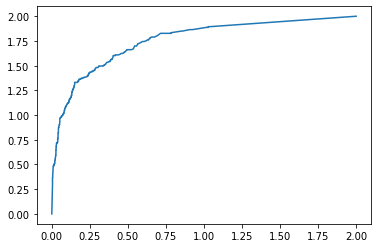

In [15]:
# Calculate the AUC score for fraudulent user prediction (Supervised)

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

scores = defaultdict(list)
f = open("./rev2_results/fng-sorted-users-%d-%d-%d-%d-%d-%d-%d.csv" % (alpha1, alpha2, beta1, beta2, gamma1, gamma2, gamma3), "r")
for l in f:
    l = l.strip().split(",")
    if l[1] == "nan": l[1] = "0"
    scores[l[0]].append(float(l[1]))
    if l[2] == "nan": l[2] = "0"
    scores[l[0]].append(float(l[2]))

X = []
Y = []
U = []
for b in benign:
    b_name = 'u' + b
    if len(scores[b_name]) > 0:
        Y.append(0)
        X.append(scores[b_name])
        U.append(b)
for f in fraudulent:
    f_name = 'u' + f
    if len(scores[f_name]) > 0:
        Y.append(1)
        X.append(scores[f_name])
        U.append(f)

X = np.array(X)
Y = np.array(Y)
U = np.array(U)
X, Y, U = shuffle(X, Y, U)
skf = StratifiedKFold(n_splits=10)
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
aucscores = []

user_preds = {}
fpr = []
tpr = []
users = []
p = []
gts = []
for train, test in skf.split(X, Y):
    train_X = X[train]
    train_Y = Y[train]
    test_X = X[test]
    test_Y = Y[test]
    test_U = U[test]

    clf = RandomForestClassifier(n_estimators=500)
    clf.fit(train_X, train_Y)
    preds = clf.predict(test_X)
    users.extend(test_U)
    p.extend(preds)
    gts.extend(test_Y)
    for user, pred, gt in list(zip(test_U, preds, test_Y)):
      user_preds[user] = [pred, gt]
    accuracy_scores.append(accuracy_score(y_true=test_Y,y_pred=preds))
    f1_scores.append(f1_score(y_true=test_Y, y_pred=preds))
    precision_scores.append(precision_score(y_true=test_Y, y_pred=preds))
    recall_scores.append(recall_score(y_true=test_Y, y_pred=preds))
    try:
        pred_Y = clf.predict_proba(test_X)
        false_positive_rate, true_positive_rate, th = roc_curve(test_Y, pred_Y[:,1])
        aucscores.append(auc(false_positive_rate, true_positive_rate))
        if not fpr: fpr = false_positive_rate
        fpr += false_positive_rate
        if not tpr: tpr = true_positive_rate
        tpr += true_positive_rate
    except:
        pass
    # print(scores[-1], aucscores[-1])

d = {'ReviewerID': users, 'Predicted Label': p, 'Ground Truth Label': gts}
preds_df = pd.DataFrame(data=d)
print(preds_df)
preds_df.to_csv(f'reviewer_preds_gt.csv', index=False)
# Print prediction result for every reviewer
print("There are ", len(user_preds), " users")
print(user_preds)
# Print metrics results
print("Accuracy scores", accuracy_scores, np.mean(accuracy_scores))
print("F1 scores", f1_scores, np.mean(f1_scores))
print("Precision scores", precision_scores, np.mean(precision_scores))
print("Recall scores", recall_scores, np.mean(recall_scores))
print("AUC scores", aucscores, np.mean(aucscores))

plt.plot(fpr, tpr)

In [16]:
metrics = {'Accuracy': [np.mean(accuracy_scores)], 'F1': [np.mean(f1_scores)], 'Precision': [np.mean(precision_scores)], 'Recall': [np.mean(recall_scores)], 'AUC': [np.mean(aucscores)]}
metrics_df = pd.DataFrame(data=metrics)
print(metrics_df)
metrics_df.to_csv(f'metrics_results.csv', index=False)
t2 = time.time()
print(t2-t1)

   Accuracy        F1  Precision    Recall      AUC
0  0.893175  0.578448   0.620519  0.542422  0.86971
217.20214819908142
